#BUSINESS CHALLENGE I - FALL TERM 24/25
## MBAN - HULT INTERNATIONAL BUSINESS SCHOOL
TEAM 4 <br>
  -Arabela Carceles <br>
  -Melek Ladhari <br>
  -Sayefaldeen Suleiman <br>
  -Abhimanyu Kankhar <br>
  -Ansh Patel <br>
  -Fernando Caballol <br>

ChatGPT used


In [58]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from lifelines import KaplanMeierFitter, CoxPHFitter
from scipy.stats import ttest_ind, chi2_contingency

##IMPORT DATASET

In [63]:
df = pd.read_csv('insurance_churn_students.csv', low_memory=False)
df.head()

,CustomerID,Age,Gender,SignUpDate,PolicyType,SubscriptionType,PolicyRenewed,Churn,CustomerLifecycleStage,ChurnDate,...,PlatformOS,AppVersion,SessionsPerWeek,SearchQueries,TrialPeriodDays,ReferralBonusUsed,NotificationsOptIn,MostVisitedPage,DropOffPage,ClaimsProcessingTime
0,3,80,Male,11/10/23,Life,Free,1,1,At Risk,2/1/24,...,MacOS,2.0,9,3.0,2,0,1,Help Center,Claims,71.0
1,27,44,Male,1/18/23,Auto,Basic,1,1,At Risk,12/5/24,...,iOS,1.0,3,49.0,21,1,1,Home Page,Checkout,61.0
2,30,40,Female,1/18/23,Auto,Free,1,1,At Risk,12/5/24,...,Android,2.0,9,46.0,28,0,0,Policy Overview,Checkout,NaN
3,36,68,Male,9/23/23,House Insurance,Family,1,1,Engaged,10/23/23,...,Windows,1.0,8,32.0,1,1,0,Claims,Home,174.0
4,46,50,Male,6/6/23,Life,Family,1,1,At Risk,12/5/24,...,Android,1.0,9,2.0,0,0,0,Payment Details,Checkout,79.0


In [65]:
#Columns + null values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CustomerID                     55000 non-null  int64  
 1   Age                            55000 non-null  int64  
 2   Gender                         55000 non-null  object 
 3   SignUpDate                     53344 non-null  object 
 4   PolicyType                     55000 non-null  object 
 5   SubscriptionType               55000 non-null  object 
 6   PolicyRenewed                  55000 non-null  int64  
 7   Churn                          55000 non-null  int64  
 8   CustomerLifecycleStage         55000 non-null  object 
 9   ChurnDate                      21762 non-null  object 
 10  TimeToChurn                    53343 non-null  float64
 11  LoginFrequencyMonthly          53350 non-null  float64
 12  FeatureUsagePercentage         55000 non-null 

## DATA CLEANING

Overview of missing values

In [69]:
# Calculating the missing values and percentages before deleting the Duplicates
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Data types of each column
data_types = df.dtypes

# Creating a DataFrame to display missing values, percentages, and data types
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage,
    'Data Type': data_types
})

# Filtering for columns with missing values
missing_data = missing_data[missing_data['Missing Values'] > 0]

# Output of the misiing_data dataframe
print(missing_data)

                       Missing Values  Percentage Data Type
SignUpDate                       1656    3.010909    object
ChurnDate                       33238   60.432727    object
TimeToChurn                      1657    3.012727   float64
LoginFrequencyMonthly            1650    3.000000   float64
AppVersion                       1650    3.000000   float64
SearchQueries                    1650    3.000000   float64
ClaimsProcessingTime            46989   85.434545   float64


Duplicate rows

In [72]:
# Count duplicate rows
duplicate_rows = df[df.duplicated()]
num_duplicates = len(duplicate_rows)

print(f"Number of duplicate rows: {num_duplicates}")

# Display the duplicate rows (optional)
print("\nDuplicate Rows:")
duplicate_rows

Number of duplicate rows: 0

Duplicate Rows:


,CustomerID,Age,Gender,SignUpDate,PolicyType,SubscriptionType,PolicyRenewed,Churn,CustomerLifecycleStage,ChurnDate,...,PlatformOS,AppVersion,SessionsPerWeek,SearchQueries,TrialPeriodDays,ReferralBonusUsed,NotificationsOptIn,MostVisitedPage,DropOffPage,ClaimsProcessingTime


Dates format --> MM-dd-yyyy

In [75]:
# Convert date columns to datetime format with a specific format
df['SignUpDate'] = pd.to_datetime(df['SignUpDate'], format='%m/%d/%y', errors='coerce')
df['ChurnDate'] = pd.to_datetime(df['ChurnDate'], format='%m/%d/%y', errors='coerce')

Remove rows with null values on SignUpDate

In [78]:
# Remove rows where SignUpDate is null directly in the original DataFrame
df.dropna(subset=['SignUpDate'], inplace=True)

# Verify the number of rows remaining
print(f"Rows remaining: {len(df)}")

Rows remaining: 53344


Check that ChurnDate is not null when Churn = 1

In [81]:
# Check rows where Churn = 1 and ChurnDate is null
invalid_rows = df[(df['Churn'] == 1) & (df['ChurnDate'].isna())]

# Count the number of invalid rows
invalid_count = invalid_rows.shape[0]

# Display results
if invalid_count == 0:
    print("All rows where Churn = 1 have a non-null ChurnDate.")
else:
    print(f"There are {invalid_count} rows where Churn = 1 but ChurnDate is null:")
    print(invalid_rows)


All rows where Churn = 1 have a non-null ChurnDate.


ChurnDate cannot be bigger than SignUpDate

In [84]:
# Check rows where ChurnDate is not null and is less than SignUpDate
invalid_rows = df[(df['ChurnDate'].notna()) & (df['ChurnDate'] < df['SignUpDate'])]

# Count the number of invalid rows
invalid_count = invalid_rows.shape[0]

# Display results
if invalid_count == 0:
    print("All rows where ChurnDate is not null have ChurnDate greater than or equal to SignUpDate.")
else:
    print(f"There are {invalid_count} rows where ChurnDate is not null but is less than SignUpDate:")
    print(invalid_rows)


All rows where ChurnDate is not null have ChurnDate greater than or equal to SignUpDate.


Churn = 1 --> ChurnDate - SignUpDate = TimeToChurn (days)

In [87]:
# Filter rows where ChurnDate is not null and TimeToChurn is not null
churn_date_and_timetochurn_not_null = df[(df['ChurnDate'].notna()) & (df['TimeToChurn'].notna())].copy()

# Calculate the number of days between SignUpDate and ChurnDate
churn_date_and_timetochurn_not_null['DaysBetween'] = (
    churn_date_and_timetochurn_not_null['ChurnDate'] - churn_date_and_timetochurn_not_null['SignUpDate']
).dt.days

# Check if TimeToChurn matches DaysBetween
invalid_time_to_churn = churn_date_and_timetochurn_not_null[
    churn_date_and_timetochurn_not_null['TimeToChurn'] != churn_date_and_timetochurn_not_null['DaysBetween']
]

# Display results
if invalid_time_to_churn.empty:
    print("All rows where ChurnDate and TimeToChurn are not null have TimeToChurn matching DaysBetween.")
else:
    print(f"There are {invalid_time_to_churn.shape[0]} rows where ChurnDate and TimeToChurn are not null but TimeToChurn does not match DaysBetween:")
    print(invalid_time_to_churn[['ChurnDate', 'SignUpDate', 'TimeToChurn', 'DaysBetween']])



All rows where ChurnDate and TimeToChurn are not null have TimeToChurn matching DaysBetween.


If TimeToChurn = null & Churn = 1 --> TimeToChurn = ChurnDate - SignUpDate

In [90]:
# Calculate the difference in days between ChurnDate and SignUpDate
df['CalculatedTimeToChurn'] = (df['ChurnDate'] - df['SignUpDate']).dt.days

# Fill NaN values in TimeToChurn for rows where Churn = 1
df.loc[(df['Churn'] == 1) & (df['TimeToChurn'].isna()), 'TimeToChurn'] = df['CalculatedTimeToChurn']

# Drop the helper column if not needed
df = df.drop(columns=['CalculatedTimeToChurn'])

# Verify the changes
print("Remaining NaN values in TimeToChurn where Churn = 1:", df[(df['Churn'] == 1) & (df['TimeToChurn'].isna())].shape[0])


Remaining NaN values in TimeToChurn where Churn = 1: 0


TimeToChurn when Churn = 0

In [93]:
# Filter rows where Churn = 0 and TimeToChurn is not null
filtered_rows = df[(df['Churn'] == 0) & (df['TimeToChurn'].notna())].copy()

# Calculate the sum of SignUpDate and TimeToChurn
filtered_rows['CalculatedDate'] = filtered_rows['SignUpDate'] + pd.to_timedelta(filtered_rows['TimeToChurn'], unit='D')

# Count the occurrence of each unique date
date_counts = filtered_rows['CalculatedDate'].value_counts()

# Print the unique dates and their counts
print("Unique dates and their counts:")
print(date_counts)


Unique dates and their counts:
CalculatedDate
2024-12-05    40812
2023-12-28       18
2023-10-06       16
2023-12-16       16
2023-12-12       15
              ...  
2023-06-26        1
2023-04-26        1
2024-07-24        1
2023-05-16        1
2024-02-21        1
Name: count, Length: 608, dtype: int64


In [95]:
# Define the target date (5th December 2024)
target_date = datetime(2024, 12, 5)

# Calculate the difference in days and fill TimeToChurn where it's NaN and Churn = 0
df.loc[(df['TimeToChurn'].isna()) & (df['Churn'] == 0), 'TimeToChurn'] = (
    target_date - df.loc[(df['TimeToChurn'].isna()) & (df['Churn'] == 0), 'SignUpDate']
).dt.days

# Verify the changes
print("Remaining NaN values in TimeToChurn:", df['TimeToChurn'].isna().sum())


Remaining NaN values in TimeToChurn: 0


ShearchQueries = null --> fill with mean

In [98]:
# Calculate the mean of the column 'SearchQueries', ignoring NaN values
mean_search_queries = df['SearchQueries'].mean()

# Fill NaN values in 'SearchQueries' with the calculated mean
df['SearchQueries'] = df['SearchQueries'].fillna(mean_search_queries)

# Verify the changes
print("Remaining NaN values in 'SearchQueries':", df['SearchQueries'].isna().sum())


Remaining NaN values in 'SearchQueries': 0


LoginFrequencyMonthly = null --> fill with 0

In [101]:
df.loc[:, 'LoginFrequencyMonthly'] = df['LoginFrequencyMonthly'].fillna(0)

# Verify that there are no NaN values remaining in the column
print("Remaining NaN values in 'LoginFrequencyMonthly':", df['LoginFrequencyMonthly'].isna().sum())

Remaining NaN values in 'LoginFrequencyMonthly': 0


In [103]:
# Check rows where both ClaimProcessingTime and ClaimsProcessingTime are not null
non_null_rows = df[df['ClaimProcessingTime'].notna() & df['ClaimsProcessingTime'].notna()]

# Verify if the values are equal in these rows
mismatch_rows = non_null_rows[non_null_rows['ClaimProcessingTime'] != non_null_rows['ClaimsProcessingTime']]

# Count mismatched rows
mismatch_count = mismatch_rows.shape[0]

# Print the result
print("Number of rows where ClaimProcessingTime and ClaimsProcessingTime do not match:", mismatch_count)

# Optionally display mismatched rows for debugging
if mismatch_count > 0:
    print(mismatch_rows)


Number of rows where ClaimProcessingTime and ClaimsProcessingTime do not match: 7767
      CustomerID  Age  Gender SignUpDate       PolicyType SubscriptionType  \
0              3   80    Male 2023-11-10             Life             Free   
1             27   44    Male 2023-01-18             Auto            Basic   
3             36   68    Male 2023-09-23  House Insurance           Family   
4             46   50    Male 2023-06-06             Life           Family   
5             53   65    Male 2023-10-22  House Insurance             Free   
...          ...  ...     ...        ...              ...              ...   
8245         242   61    Male 2023-07-30             Life             Free   
8246         796   34  Female 2023-06-19            Sport            Basic   
8247         916   57  Female 2023-03-10  House Insurance            Basic   
8248          13   30  Female 2023-05-22             Auto            Basic   
8249         654   46  Female 2023-12-21             Life

Customers ID's have to be unique

In [106]:
# Count the number of unique CustomerID values
unique_customer_ids = df['CustomerID'].nunique()

# Print the result
print("Number of unique CustomerID values:", unique_customer_ids)


Number of unique CustomerID values: 1000


In [108]:
# Create new unique CustomerID values starting from 1
df['CustomerID'] = range(1, len(df) + 1)

# Verify the change
print("New unique CustomerID values assigned.")
print(df['CustomerID'].head())


New unique CustomerID values assigned.
0    1
1    2
2    3
3    4
4    5
Name: CustomerID, dtype: int64


In [110]:
df = df.drop(columns=['ClaimsProcessingTime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53344 entries, 0 to 54999
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CustomerID                     53344 non-null  int64         
 1   Age                            53344 non-null  int64         
 2   Gender                         53344 non-null  object        
 3   SignUpDate                     53344 non-null  datetime64[ns]
 4   PolicyType                     53344 non-null  object        
 5   SubscriptionType               53344 non-null  object        
 6   PolicyRenewed                  53344 non-null  int64         
 7   Churn                          53344 non-null  int64         
 8   CustomerLifecycleStage         53344 non-null  object        
 9   ChurnDate                      8022 non-null   datetime64[ns]
 10  TimeToChurn                    53344 non-null  float64       
 11  LoginFrequencyMonthl

#EDA

Correlation Matrix

In [114]:
# Create dummy variables for categorical columns
df_with_dummies = pd.get_dummies(df, drop_first=True)

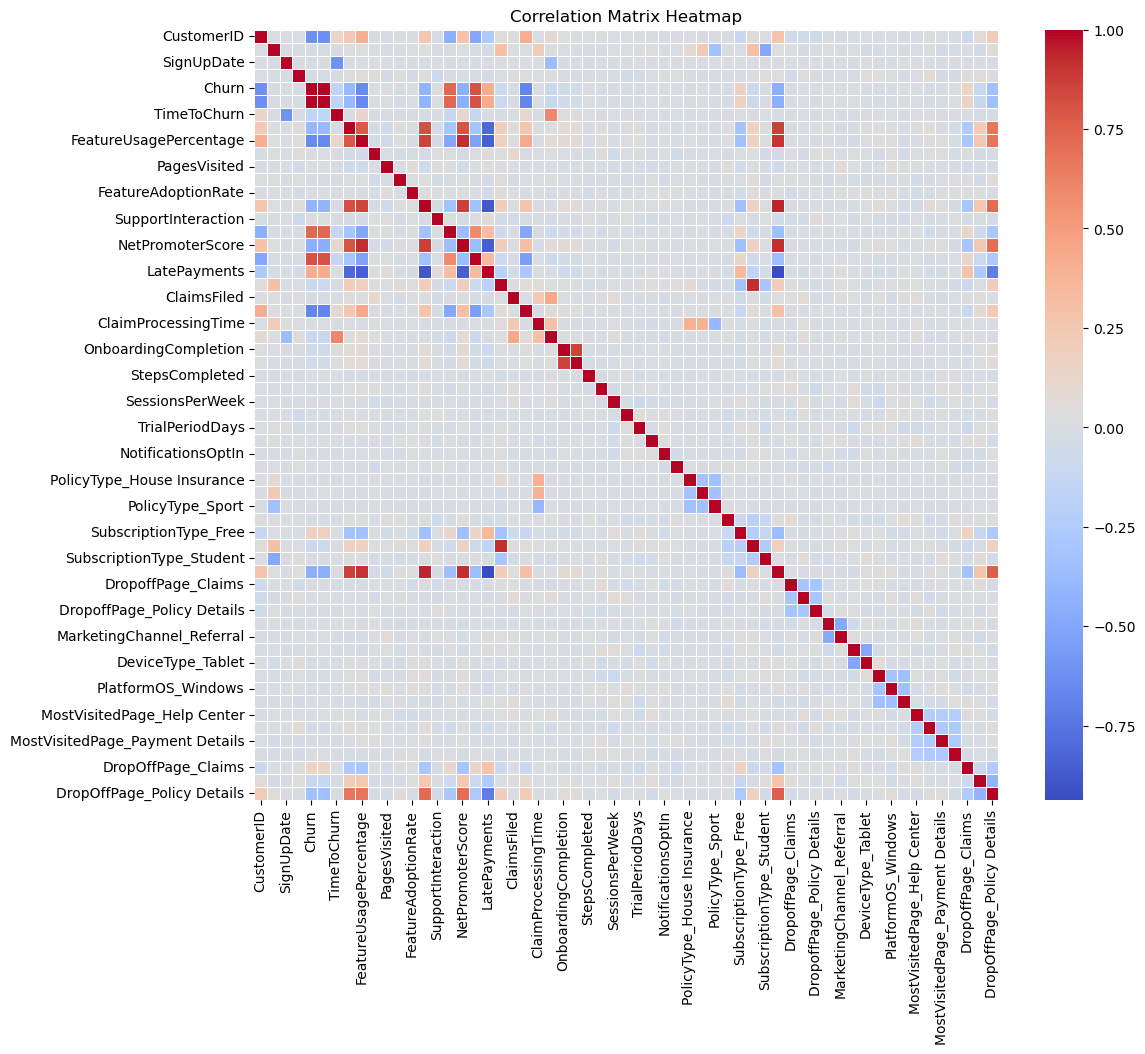

In [116]:

# Calculate the correlation matrix for numeric columns
correlation_matrix = df_with_dummies.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Add a title
plt.title("Correlation Matrix Heatmap")
plt.show()


In [118]:
# Get the correlation of each variable with a target variable, e.g., 'Churn'
target_variable = 'Churn'
correlation_with_target = correlation_matrix[target_variable].sort_values(ascending=False)

# Display the sorted correlations
print("Correlations with", target_variable, "sorted in descending order:")
print(correlation_with_target)

Correlations with Churn sorted in descending order:
Churn                              1.000000
ChurnDate                          0.999999
PaymentsMissed                     0.808135
CustomerComplaints                 0.735219
LatePayments                       0.418863
SubscriptionType_Free              0.166646
DropOffPage_Claims                 0.152424
PagesVisited                       0.021610
SupportInteraction                 0.019259
AverageSessionDurationMinutes      0.013865
MostVisitedPage_Policy Overview    0.012654
DeviceType_Mobile                  0.010655
PolicyType_Life                    0.009172
MarketingChannel_Referral          0.009047
MostVisitedPage_Help Center        0.007598
Gender_Male                        0.006993
StepsCompleted                     0.006319
MarketingChannel_Online            0.005911
ClaimProcessingTime                0.005154
PlatformOS_iOS                     0.004181
FeatureAdoptionRate                0.003165
ReferralBonusUsed       

#t-Test

In [121]:
from scipy.stats import ttest_ind

# Define numerical features for t-tests
numerical_features = ['PaymentsMissed', 'CustomerComplaints', 'LatePayments',
                      'NetPromoterScore', 'FeatureUsagePercentage', 'LoginFrequencyMonthly']

# Conduct t-tests for numerical features
print("T-Test Results:")
for feature in numerical_features:
    churned = df[df['Churn'] == 1][feature]
    non_churned = df[df['Churn'] == 0][feature]
    t_stat, p_value = ttest_ind(churned, non_churned, nan_policy='omit')
    significance = "Significant" if p_value < 0.05 else "Not Significant"
    print(f"{feature}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f} ({significance})")

T-Test Results:
PaymentsMissed: t-statistic = 316.8871, p-value = 0.0000 (Significant)
CustomerComplaints: t-statistic = 250.5135, p-value = 0.0000 (Significant)
LatePayments: t-statistic = 106.5362, p-value = 0.0000 (Significant)
NetPromoterScore: t-statistic = -118.2993, p-value = 0.0000 (Significant)
FeatureUsagePercentage: t-statistic = -198.9998, p-value = 0.0000 (Significant)
LoginFrequencyMonthly: t-statistic = -97.1972, p-value = 0.0000 (Significant)


#Chi-Square

In [125]:
from scipy.stats import chi2_contingency

# Define categorical features for chi-square tests
categorical_features = ['SubscriptionType', 'DropOffPage', 'CustomerLifecycleStage']

# Conduct chi-square tests for categorical features
print("\nChi-Square Test Results:")
for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['Churn'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    significance = "Significant" if p < 0.05 else "Not Significant"
    print(f"{feature}: chi2-statistic = {chi2:.4f}, p-value = {p:.4f} ({significance})")


Chi-Square Test Results:
SubscriptionType: chi2-statistic = 1603.2947, p-value = 0.0000 (Significant)
DropOffPage: chi2-statistic = 10638.0627, p-value = 0.0000 (Significant)
CustomerLifecycleStage: chi2-statistic = 10633.1383, p-value = 0.0000 (Significant)


#CLUSTERING

Number of clusters needed

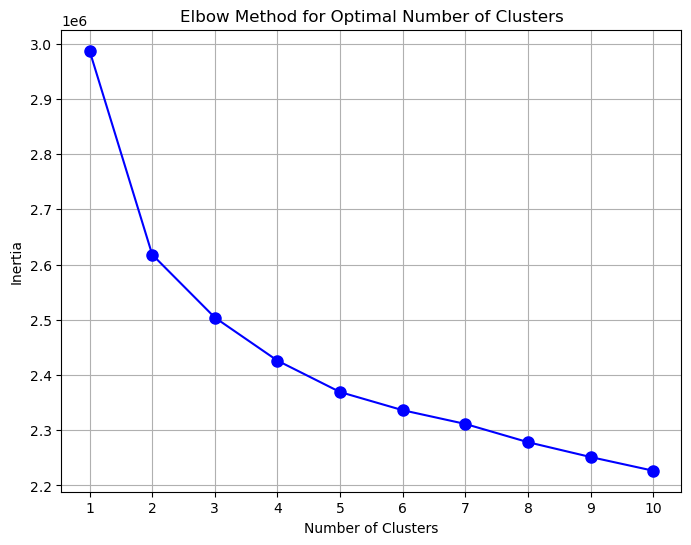

In [129]:
# Step 1: Select relevant data types for clustering --> Not dates
df_processed = df_with_dummies.select_dtypes(include=['float64', 'int64', 'uint8', 'bool']).copy()

# Step 2: Drop columns with NaN values or constant values
df_processed = df_processed.dropna(axis=1, how='any')
df_processed = df_processed.loc[:, (df_processed != df_processed.iloc[0]).any()]


# Step 3: Standardize the data --> mean = 0, std = 1
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_processed)

# Step 4: Determine the number of clusters using the elbow method
inertia = []  # List to store the inertia (within-cluster sum of squares) for each value of k
K = range(1, 11)  # Test clustering for k values from 1 to 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Step 5: Plot the elbow curve
plt.figure(figsize=(8, 6))  # Set the figure size for the plot
plt.plot(K, inertia, 'bo-', markersize=8)
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(K)
plt.grid()
plt.show()


In [131]:
#Apply K-Means Clustering with 2 Clusters
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)

# Add cluster labels to the original DataFrame
df_with_dummies['Cluster'] = cluster_labels


#Summary of Clusters
print("\nCluster Distribution:")
print(df_with_dummies['Cluster'].value_counts())

#Display Cluster Centers
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=df_processed.columns)
print("\nCluster Centers:")
cluster_centers


Cluster Distribution:
Cluster
1    34517
0    18827
Name: count, dtype: int64

Cluster Centers:


,CustomerID,Age,PolicyRenewed,Churn,TimeToChurn,LoginFrequencyMonthly,FeatureUsagePercentage,AverageSessionDurationMinutes,PagesVisited,CTAClicked,...,PlatformOS_MacOS,PlatformOS_Windows,PlatformOS_iOS,MostVisitedPage_Help Center,MostVisitedPage_Home Page,MostVisitedPage_Payment Details,MostVisitedPage_Policy Overview,DropOffPage_Claims,DropOffPage_Home,DropOffPage_Policy Details
0,19366.871355,41.970840,0.687683,0.421204,474.110639,3.203909,9.289283,18.259163,27.569129,0.666437,...,0.212408,0.216816,0.286822,0.172678,0.183991,0.199766,0.224465,1.417645e-01,0.014129,0.054602
1,30657.292146,42.935539,0.712287,0.002665,509.238404,14.119101,84.758881,17.821137,26.119506,0.701799,...,0.252803,0.245531,0.267086,0.164528,0.221833,0.227917,0.204015,-4.586609e-15,0.188632,0.811368


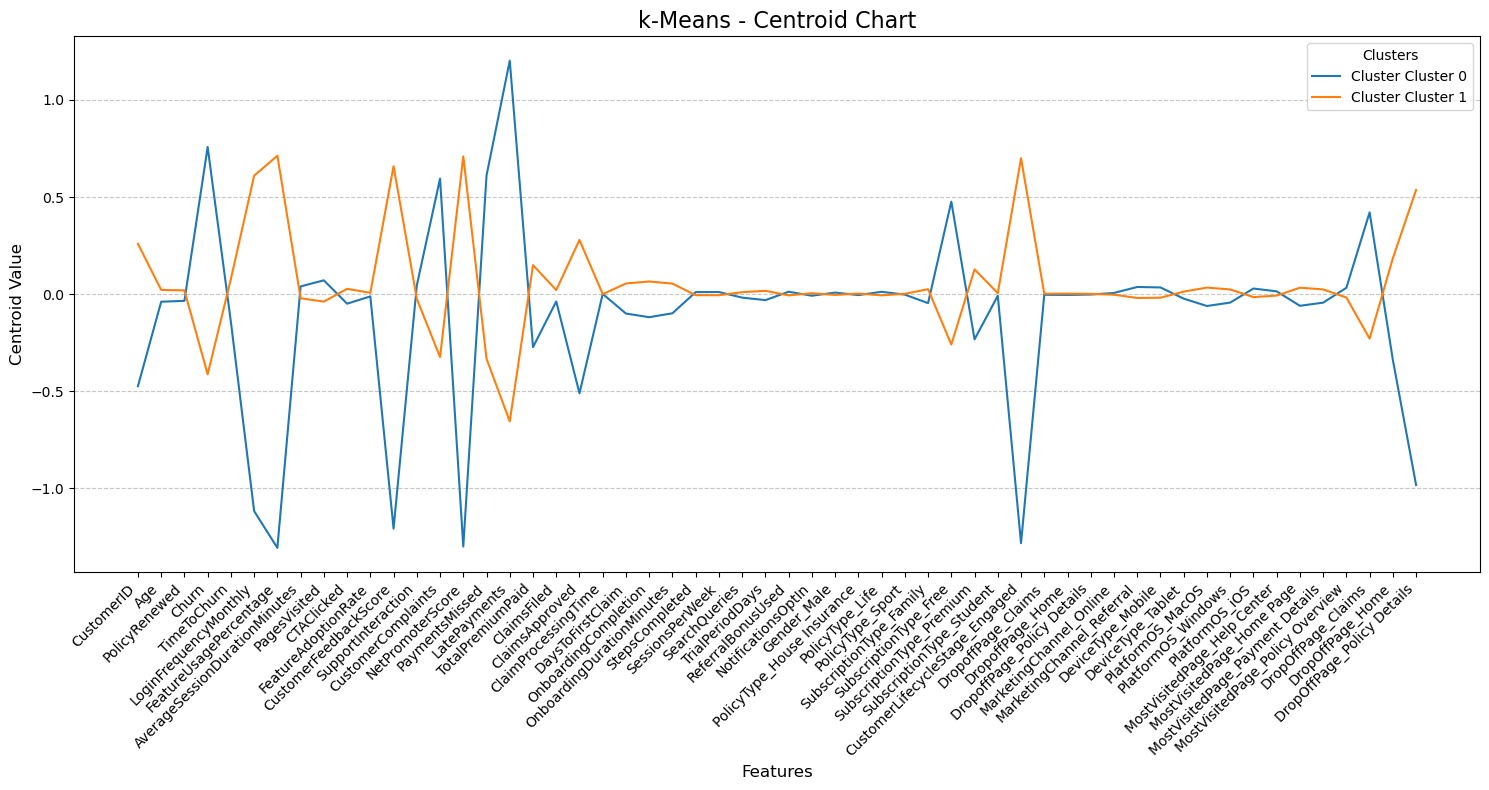

In [133]:
#Create a centroid chart
centroids = kmeans.cluster_centers_

# Convert cluster centers to a DataFrame for visualization
centroid_df = pd.DataFrame(centroids, columns=df_processed.columns, index=[f"Cluster {i}" for i in range(len(centroids))])

# Transpose the DataFrame for easier plotting
centroid_table_transposed = centroid_df.T

plt.figure(figsize=(15, 8))
for cluster in centroid_table_transposed.columns:
    plt.plot(centroid_table_transposed.index, centroid_table_transposed[cluster], label=f'Cluster {cluster}')

plt.title("k-Means - Centroid Chart", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Centroid Value", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title="Clusters", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [135]:
# Extract the profile for Cluster 0
cluster_0_profile = cluster_centers.iloc[0]  # Row corresponding to Cluster 1

# Print the profile of Cluster 1, sorted in descending order by feature values
print("Profile of Cluster 0:")
print(cluster_0_profile)  # Sort to highlight key features


Profile of Cluster 0:
CustomerID                         19366.871355
Age                                   41.970840
PolicyRenewed                          0.687683
Churn                                  0.421204
TimeToChurn                          474.110639
LoginFrequencyMonthly                  3.203909
FeatureUsagePercentage                 9.289283
AverageSessionDurationMinutes         18.259163
PagesVisited                          27.569129
CTAClicked                             0.666437
FeatureAdoptionRate                    0.497687
CustomerFeedbackScore                  1.731981
SupportInteraction                     4.730918
CustomerComplaints                     3.595846
NetPromoterScore                     -65.946407
PaymentsMissed                         1.495034
LatePayments                           3.773198
TotalPremiumPaid                     237.960473
ClaimsFiled                            1.910766
ClaimsApproved                         1.791470
ClaimProcessingTim

In [137]:
# Extract the profile for Cluster 1
cluster_1_profile = cluster_centers.iloc[1]  # Row corresponding to Cluster 1
# Print the profile of Cluster 1, sorted in descending order by feature values
print("Profile of Cluster 1:")
print(cluster_1_profile)  # Sort to highlight key features


Profile of Cluster 1:
CustomerID                         3.065729e+04
Age                                4.293554e+01
PolicyRenewed                      7.122867e-01
Churn                              2.665353e-03
TimeToChurn                        5.092384e+02
LoginFrequencyMonthly              1.411910e+01
FeatureUsagePercentage             8.475888e+01
AverageSessionDurationMinutes      1.782114e+01
PagesVisited                       2.611951e+01
CTAClicked                         7.017991e-01
FeatureAdoptionRate                5.030317e-01
CustomerFeedbackScore              4.489005e+00
SupportInteraction                 4.532810e+00
CustomerComplaints                 9.262682e-01
NetPromoterScore                   7.407924e+01
PaymentsMissed                     4.055683e-01
LatePayments                       4.871802e-01
TotalPremiumPaid                   3.664423e+02
ClaimsFiled                        1.993047e+00
ClaimsApproved                     2.794044e+00
ClaimProcessingTim

Clustering, for customers in Cluster 0

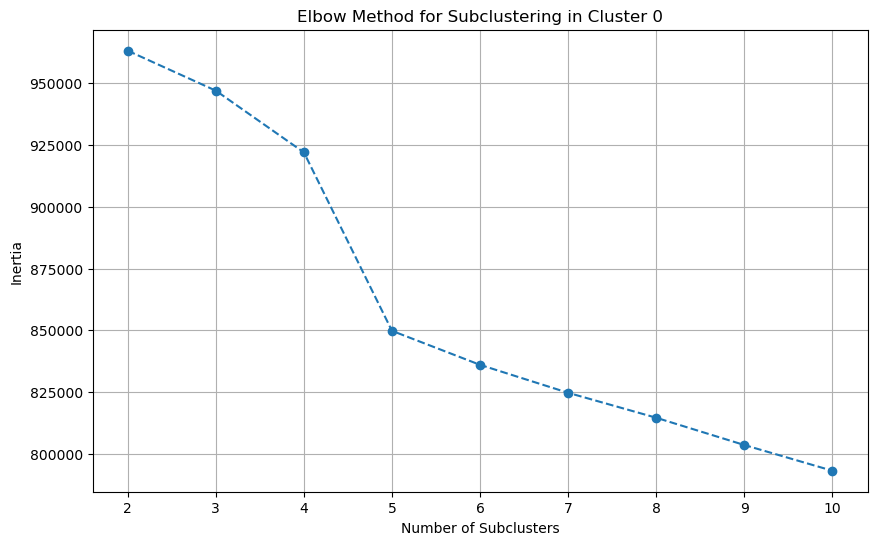

In [140]:
#Filter data for Cluster 0
cluster_0 = df_with_dummies[df_with_dummies['Cluster'] == 0].drop(columns=['Cluster'])
# Select numeric and binary columns only --> No dates
cluster_0_processesd = cluster_0.select_dtypes(include=['float64', 'int64', 'uint8','bool']).copy()

# Drop columns with NaN or constant values
cluster_0_processesd = cluster_0_processesd.dropna(axis=1, how='any')
cluster_0_processesd = cluster_0_processesd.loc[:, (cluster_0_processesd != cluster_0_processesd.iloc[0]).any()]

#Scale the filtered data
scaler_sub = StandardScaler()
cluster_0_scaled = scaler_sub.fit_transform(cluster_0_processesd)

#Elbow Method to determine the optimal number of subclusters
inertia = []

# Test different numbers of subclusters
for n_clusters in range(2, 11):  # Test from 2 to 10 subclusters
    kmeans_sub = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_sub.fit(cluster_0_scaled)
    inertia.append(kmeans_sub.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Subclustering in Cluster 0")
plt.xlabel("Number of Subclusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()

In [142]:
#Apply K-Means Clustering with 3 Clusters
kmeans_sub = KMeans(n_clusters=3, random_state=42)
subcluster_labels = kmeans_sub.fit_predict(cluster_0_scaled)

# Assign the predicted subclusters back to the original filtered DataFrame
cluster_0['SubCluster'] = subcluster_labels

# Step 5: Summary of Clusters
print("\nSubCluster Distribution:")
print(cluster_0['SubCluster'].value_counts())

# Optional: Display Cluster Centers
subcluster_centers = pd.DataFrame(scaler_sub.inverse_transform(kmeans_sub.cluster_centers_), columns=cluster_0_processesd.columns)
print("\nSubCluster Centers:")
subcluster_centers



SubCluster Distribution:
SubCluster
1    10139
2     7431
0     1257
Name: count, dtype: int64

SubCluster Centers:


,CustomerID,Age,PolicyRenewed,Churn,TimeToChurn,LoginFrequencyMonthly,FeatureUsagePercentage,AverageSessionDurationMinutes,PagesVisited,CTAClicked,...,PlatformOS_MacOS,PlatformOS_Windows,PlatformOS_iOS,MostVisitedPage_Help Center,MostVisitedPage_Home Page,MostVisitedPage_Payment Details,MostVisitedPage_Policy Overview,DropOffPage_Claims,DropOffPage_Home,DropOffPage_Policy Details
0,19772.381862,43.005569,0.760541,0.396181,500.505171,2.249801,8.601062,16.769000,29.233890,0.827367,...,0.129674,0.278441,0.448687,0.091488,0.163882,0.229117,0.271281,0.205251,-6.765422e-17,-3.608225e-16
1,30573.847125,41.800967,0.682809,0.000099,500.256929,2.418187,16.072642,18.416110,27.635862,0.649768,...,0.214321,0.208699,0.281586,0.178814,0.187297,0.192820,0.221718,0.146366,9.957313e-16,3.011480e-15
2,4007.262414,42.027587,0.682008,1.000000,433.971336,4.437357,0.150353,18.297092,27.196474,0.661957,...,0.223792,0.217467,0.266586,0.178038,0.182883,0.204279,0.220293,0.124748,3.579599e-02,1.383394e-01


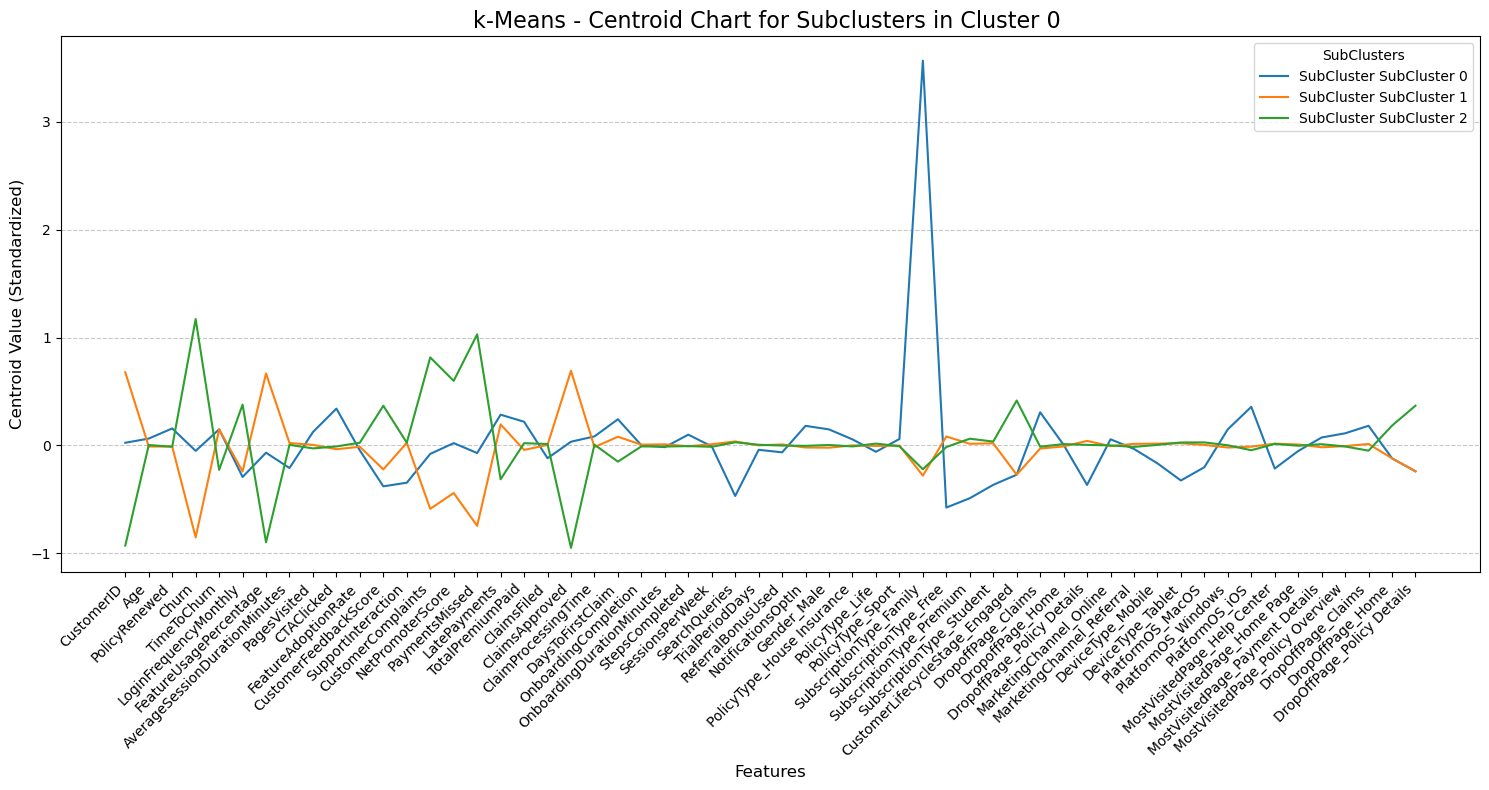

In [144]:
# Centroid chart
sub_centroids = kmeans_sub.cluster_centers_
subcentroid_table = pd.DataFrame(sub_centroids, columns=cluster_0_processesd.columns, index=[f"SubCluster {i}" for i in range(len(sub_centroids))])
subcentroid_table_transposed = subcentroid_table.T

# Step 5: Create a line chart for the subcluster centroids
plt.figure(figsize=(15, 8))
for subcluster in subcentroid_table_transposed.columns:
    plt.plot(subcentroid_table_transposed.index, subcentroid_table_transposed[subcluster], label=f'SubCluster {subcluster}')

plt.title("k-Means - Centroid Chart for Subclusters in Cluster 0 ", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Centroid Value (Standardized)", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title="SubClusters", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [146]:
# Extract the profile for SubCluster 0
sub_cluster_0_profile = subcluster_centers.iloc[0]  # Row corresponding to SubCluster 0

# Print the profile of SubCluster 0, sorted in descending order by feature values
print("Profile of SubCluster 0:")
print(sub_cluster_0_profile)  # Sort to highlight key features


Profile of SubCluster 0:
CustomerID                         1.977238e+04
Age                                4.300557e+01
PolicyRenewed                      7.605410e-01
Churn                              3.961814e-01
TimeToChurn                        5.005052e+02
LoginFrequencyMonthly              2.249801e+00
FeatureUsagePercentage             8.601062e+00
AverageSessionDurationMinutes      1.676900e+01
PagesVisited                       2.923389e+01
CTAClicked                         8.273667e-01
FeatureAdoptionRate                4.837446e-01
CustomerFeedbackScore              1.391408e+00
SupportInteraction                 3.755768e+00
CustomerComplaints                 3.264916e+00
NetPromoterScore                  -6.541368e+01
PaymentsMissed                     1.390613e+00
LatePayments                       4.112967e+00
TotalPremiumPaid                   2.978471e+02
ClaimsFiled                        1.747017e+00
ClaimsApproved                     1.841687e+00
ClaimProcessing

In [148]:
# Extract the profile for SubCluster 1
sub_cluster_1_profile = subcluster_centers.iloc[1]  # Row corresponding to SubCluster 1

# Print the profile of SubCluster 1, sorted in descending order
print("Profile of SubCluster 1:")
print(sub_cluster_1_profile)


Profile of SubCluster 1:
CustomerID                         3.057385e+04
Age                                4.180097e+01
PolicyRenewed                      6.828090e-01
Churn                              9.862906e-05
TimeToChurn                        5.002569e+02
LoginFrequencyMonthly              2.418187e+00
FeatureUsagePercentage             1.607264e+01
AverageSessionDurationMinutes      1.841611e+01
PagesVisited                       2.763586e+01
CTAClicked                         6.497682e-01
FeatureAdoptionRate                4.939306e-01
CustomerFeedbackScore              1.532104e+00
SupportInteraction                 4.800079e+00
CustomerComplaints                 1.124371e+00
NetPromoterScore                  -7.697386e+01
PaymentsMissed                     3.941217e-01
LatePayments                       4.005622e+00
TotalPremiumPaid                   2.264352e+02
ClaimsFiled                        1.917447e+00
ClaimsApproved                     2.805701e+00
ClaimProcessing

In [150]:
# Extract the profile for SubCluster 2
sub_cluster_2_profile = subcluster_centers.iloc[2]  # Row corresponding to SubCluster 2

# Print the profile of SubCluster 2, sorted in descending order by feature values
print("Profile of SubCluster 2:")
print(sub_cluster_2_profile)  # Sort to highlight key features


Profile of SubCluster 2:
CustomerID                         4007.262414
Age                                  42.027587
PolicyRenewed                         0.682008
Churn                                 1.000000
TimeToChurn                         433.971336
LoginFrequencyMonthly                 4.437357
FeatureUsagePercentage                0.150353
AverageSessionDurationMinutes        18.297092
PagesVisited                         27.196474
CTAClicked                            0.661957
FeatureAdoptionRate                   0.505171
CustomerFeedbackScore                 2.062307
SupportInteraction                    4.801507
CustomerComplaints                    7.023954
NetPromoterScore                    -50.990445
PaymentsMissed                        3.014803
LatePayments                          3.398600
TotalPremiumPaid                    243.555560
ClaimsFiled                           1.929350
ClaimsApproved                        0.399139
ClaimProcessingTime                

In [152]:
# Extract the profile for SubCluster 3
sub_cluster_3_profile = subcluster_centers.iloc[2]  # Row corresponding to SubCluster 3

# Print the profile of SubCluster 3, sorted in descending order by feature values
print("Profile of SubCluster 3:")
print(sub_cluster_3_profile)  # Sort to highlight key features


Profile of SubCluster 3:
CustomerID                         4007.262414
Age                                  42.027587
PolicyRenewed                         0.682008
Churn                                 1.000000
TimeToChurn                         433.971336
LoginFrequencyMonthly                 4.437357
FeatureUsagePercentage                0.150353
AverageSessionDurationMinutes        18.297092
PagesVisited                         27.196474
CTAClicked                            0.661957
FeatureAdoptionRate                   0.505171
CustomerFeedbackScore                 2.062307
SupportInteraction                    4.801507
CustomerComplaints                    7.023954
NetPromoterScore                    -50.990445
PaymentsMissed                        3.014803
LatePayments                          3.398600
TotalPremiumPaid                    243.555560
ClaimsFiled                           1.929350
ClaimsApproved                        0.399139
ClaimProcessingTime                

Clustering, for customers in subcluster 0

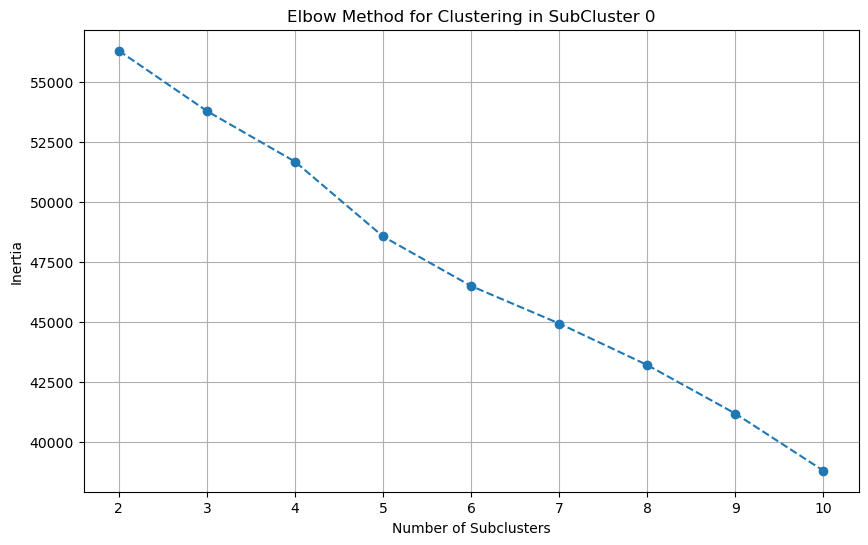

In [155]:
#Select columns needed for clustering + avoid date columns
subcluster_0 = cluster_0[cluster_0['SubCluster']==0].drop(columns=['SubCluster'])
subcluster_0_processesd = subcluster_0.select_dtypes(include=['float64', 'int64', 'uint8','bool']).copy()

# Drop columns with NaN or constant values
subcluster_0_processesd = subcluster_0_processesd.dropna(axis=1, how='any')
subcluster_0_processesd = subcluster_0_processesd.loc[:, (subcluster_0_processesd != subcluster_0_processesd.iloc[0]).any()]

#Scale the filtered data
scaler_sub_sub = StandardScaler()
subcluster_0_scaled = scaler_sub_sub.fit_transform(subcluster_0_processesd)

#Elbow Method to determine the optimal number of subclusters
inertia = []

# Test different numbers of subclusters
for n_clusters in range(2, 11):  # Test from 2 to 10 subclusters
    kmeans_sub = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_sub.fit(subcluster_0_scaled)
    inertia.append(kmeans_sub.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Clustering in SubCluster 0")
plt.xlabel("Number of Subclusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()

In [157]:
#Apply K-Means Clustering with 3 Clusters
kmeans_sub_sub = KMeans(n_clusters=2, random_state=42)
sub_subcluster_labels = kmeans_sub_sub.fit_predict(subcluster_0_scaled)

# Assign the predicted subclusters back to the original filtered DataFrame
subcluster_0['Sub_SubCluster'] = sub_subcluster_labels

# Step 5: Summary of Clusters
print("\nSub-SubCluster Distribution:")
print(subcluster_0['Sub_SubCluster'].value_counts())

# Optional: Display Cluster Centers
sub_subcluster_centers = pd.DataFrame(scaler_sub_sub.inverse_transform(kmeans_sub_sub.cluster_centers_), columns=subcluster_0_processesd.columns)
print("\nSUb-SubCluster Centers:")
sub_subcluster_centers



Sub-SubCluster Distribution:
Sub_SubCluster
1    759
0    498
Name: count, dtype: int64

SUb-SubCluster Centers:


,CustomerID,Age,PolicyRenewed,Churn,TimeToChurn,LoginFrequencyMonthly,FeatureUsagePercentage,AverageSessionDurationMinutes,PagesVisited,CTAClicked,...,DeviceType_Mobile,DeviceType_Tablet,PlatformOS_MacOS,PlatformOS_Windows,PlatformOS_iOS,MostVisitedPage_Help Center,MostVisitedPage_Home Page,MostVisitedPage_Payment Details,MostVisitedPage_Policy Overview,DropOffPage_Claims
0,3913.293173,43.024096,0.751004,1.000000e+00,498.014056,2.295181,0.151006,17.067175,29.648594,0.823293,...,0.277108,0.168675,0.134538,0.295181,0.461847,0.092369,0.150602,0.212851,0.283133,0.216867
1,30177.949934,42.993412,0.766798,-2.386980e-15,502.139657,2.220026,14.145367,16.573360,28.961792,0.830040,...,0.295125,0.150198,0.126482,0.267457,0.440053,0.090909,0.172596,0.239789,0.263505,0.197628


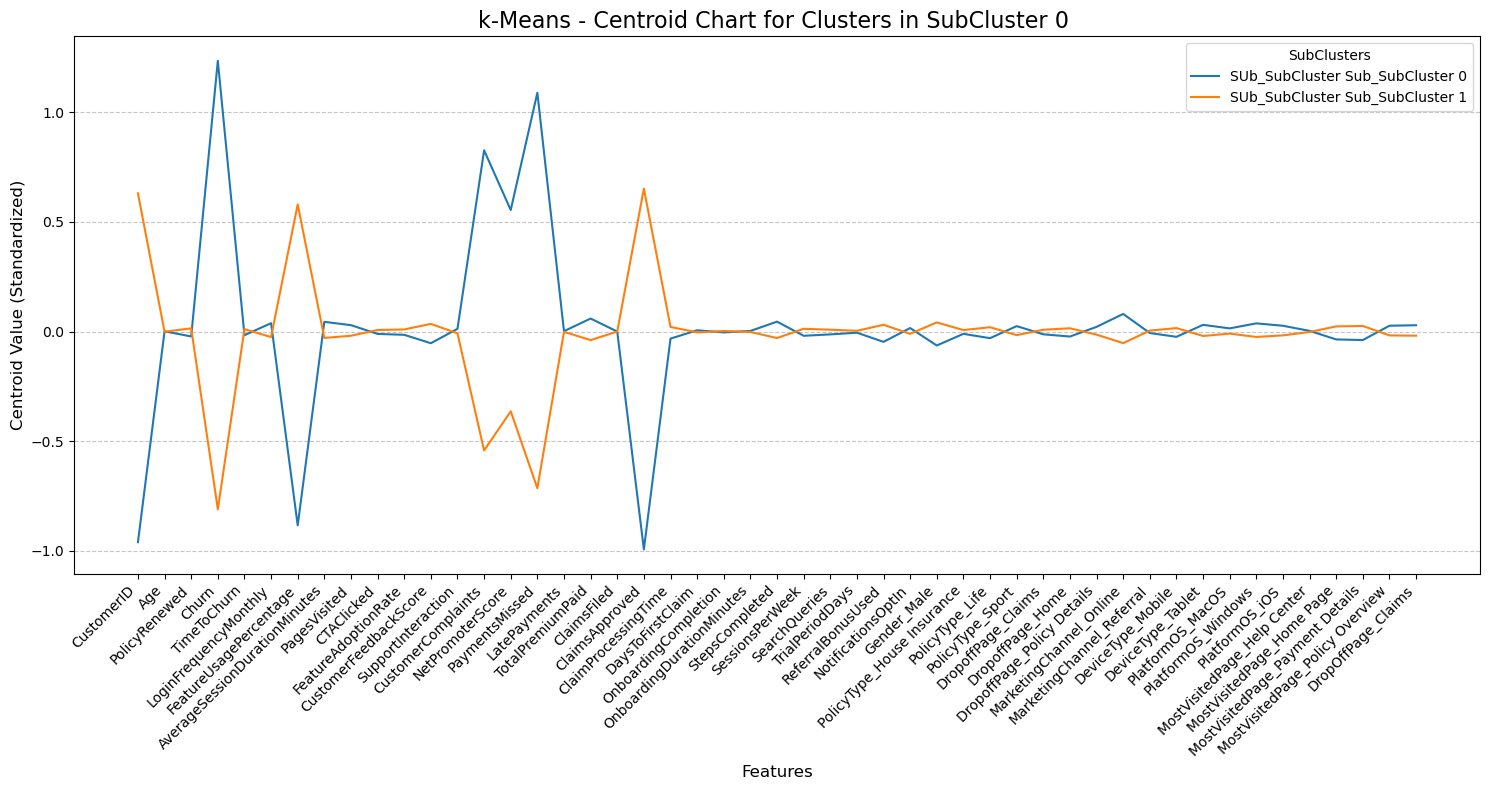

In [159]:
# Transpose the centroid table so features are on the x-axis
sub_sub_centroids = kmeans_sub_sub.cluster_centers_
sub_subcentroid_table = pd.DataFrame(sub_sub_centroids, columns=subcluster_0_processesd.columns, index=[f"Sub_SubCluster {i}" for i in range(len(sub_sub_centroids))])
sub_subcentroid_table_transposed = sub_subcentroid_table.T

# Step 5: Create a line chart for the subcluster centroids
plt.figure(figsize=(15, 8))
for subcluster in sub_subcentroid_table_transposed.columns:
    plt.plot(sub_subcentroid_table_transposed.index, sub_subcentroid_table_transposed[subcluster], label=f'SUb_SubCluster {subcluster}')

plt.title("k-Means - Centroid Chart for Clusters in SubCluster 0 ", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Centroid Value (Standardized)", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title="SubClusters", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [161]:
# Extract the profile for SubCluster 0
sub_sub_cluster_0_profile = sub_subcluster_centers.iloc[0]  # Row corresponding to SubCluster 0

# Print the profile of SubCluster 0, sorted in descending order by feature values
print("Profile of Sub_SubCluster 0:")
print(sub_sub_cluster_0_profile)  # Sort to highlight key features


Profile of Sub_SubCluster 0:
CustomerID                         3913.293173
Age                                  43.024096
PolicyRenewed                         0.751004
Churn                                 1.000000
TimeToChurn                         498.014056
LoginFrequencyMonthly                 2.295181
FeatureUsagePercentage                0.151006
AverageSessionDurationMinutes        17.067175
PagesVisited                         29.648594
CTAClicked                            0.823293
FeatureAdoptionRate                   0.479313
CustomerFeedbackScore                 1.365462
SupportInteraction                    3.789157
CustomerComplaints                    6.618474
NetPromoterScore                    -52.538153
PaymentsMissed                        2.987952
LatePayments                          4.114458
TotalPremiumPaid                    301.223964
ClaimsFiled                           1.746988
ClaimsApproved                        0.381526
ClaimProcessingTime            

In [163]:
# Extract the profile for SubCluster 0
sub_sub_cluster_1_profile = sub_subcluster_centers.iloc[1]  # Row corresponding to SubCluster 0

# Print the profile of SubCluster 0, sorted in descending order by feature values
print("Profile of Sub_SubCluster 1:")
print(sub_sub_cluster_1_profile)  # Sort to highlight key features


Profile of Sub_SubCluster 1:
CustomerID                         3.017795e+04
Age                                4.299341e+01
PolicyRenewed                      7.667984e-01
Churn                             -2.386980e-15
TimeToChurn                        5.021397e+02
LoginFrequencyMonthly              2.220026e+00
FeatureUsagePercentage             1.414537e+01
AverageSessionDurationMinutes      1.657336e+01
PagesVisited                       2.896179e+01
CTAClicked                         8.300395e-01
FeatureAdoptionRate                4.866525e-01
CustomerFeedbackScore              1.408432e+00
SupportInteraction                 3.733860e+00
CustomerComplaints                 1.064559e+00
NetPromoterScore                  -7.386166e+01
PaymentsMissed                     3.425560e-01
LatePayments                       4.111989e+00
TotalPremiumPaid                   2.956315e+02
ClaimsFiled                        1.747036e+00
ClaimsApproved                     2.799736e+00
ClaimProces

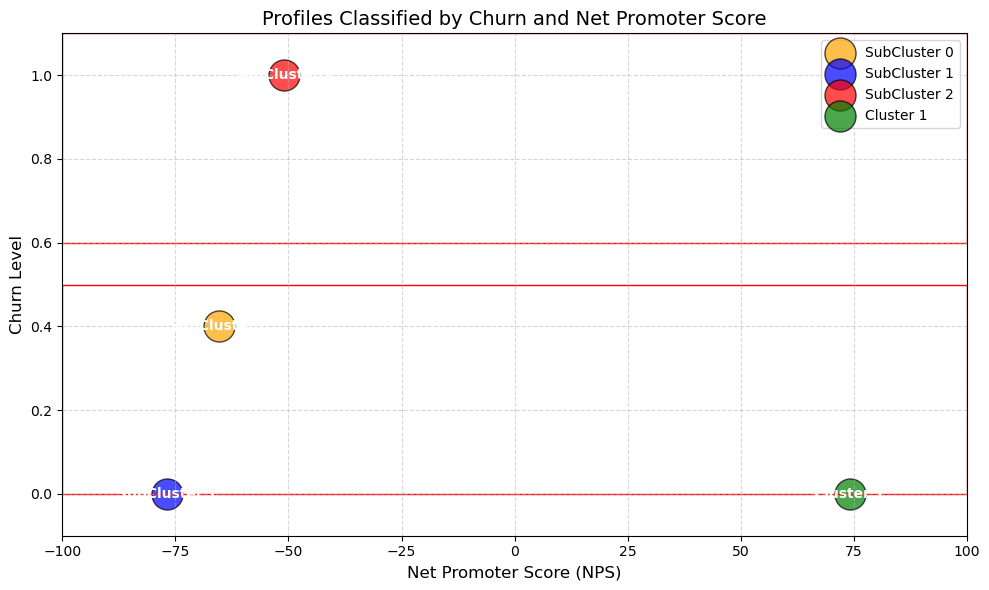

In [165]:
import matplotlib.patches as patches

# Sample data for the 3 subclusters
profiles = {
    'SubCluster 0': {'churn': 0.40, 'nps': -65.4, 'label': 'SubCluster 0', 'color': 'orange'},
    'SubCluster 1': {'churn': 0.00, 'nps': -76.9, 'label': 'SubCluster 1', 'color': 'blue'},
    'SubCluster 2': {'churn': 1.00, 'nps': -50.9, 'label': 'SubCluster 2', 'color': 'red'},
    'Cluster 1':    {'churn': 0.00, 'nps': 74.1,  'label': 'Cluster 1',    'color': 'green'},
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each profile on the graph
for profile, data in profiles.items():
    ax.scatter(data['nps'], data['churn'], s=500, c=data['color'], alpha=0.7, edgecolor='k', label=data['label'])
    ax.text(data['nps'], data['churn'], profile, fontsize=10, ha='center', va='center', color='white', weight='bold')

# Add grid and limits
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlim(-100, 100)  # NPS ranges from -100 to 100
ax.set_ylim(-0.1, 1.1)  # Churn ranges from 0 to 1

# Labels and title
ax.set_xlabel('Net Promoter Score (NPS)', fontsize=12)
ax.set_ylabel('Churn Level', fontsize=12)
ax.set_title('Profiles Classified by Churn and Net Promoter Score', fontsize=14)

# Optional: Adding rectangle regions for visual boundaries
rect1 = patches.Rectangle((-100, 0.6), 200, 0.5, linewidth=1, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((-100, 0), 200, 0.5, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)

# Display legend
ax.legend()

plt.tight_layout()
plt.show()


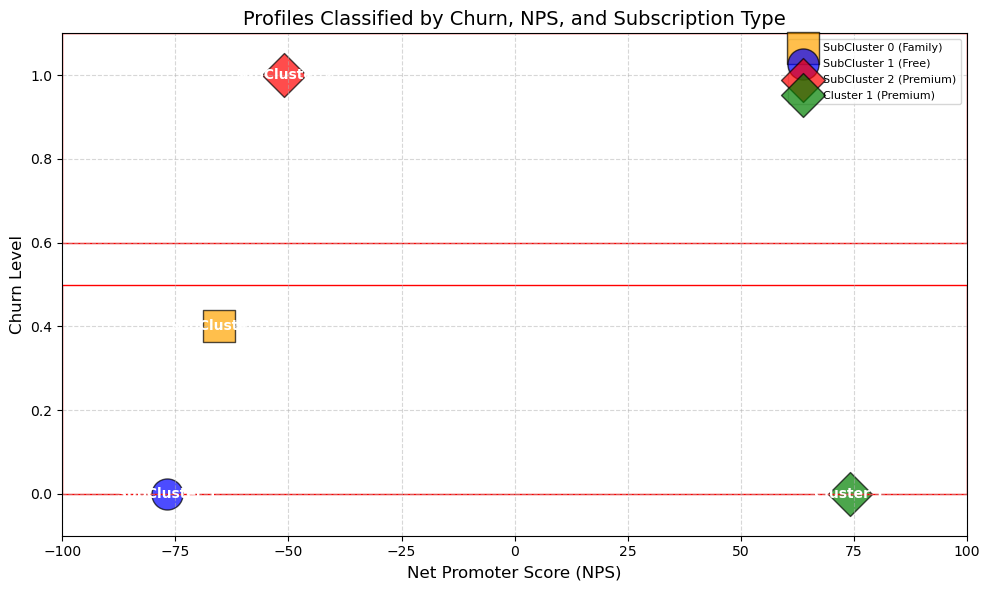

In [167]:

# Sample data for the subclusters including subscription type
profiles = {
    'SubCluster 0': {'churn': 0.40, 'nps': -65.4, 'subscription': 'Family', 'label': 'SubCluster 0', 'color': 'orange', 'marker': 's'},
    'SubCluster 1': {'churn': 0.00, 'nps': -76.9, 'subscription': 'Free',   'label': 'SubCluster 1', 'color': 'blue',   'marker': 'o'},
    'SubCluster 2': {'churn': 1.00, 'nps': -50.9, 'subscription': 'Premium', 'label': 'SubCluster 2', 'color': 'red',   'marker': 'D'},
    'Cluster 1':    {'churn': 0.00, 'nps': 74.1,  'subscription': 'Premium', 'label': 'Cluster 1',    'color': 'green', 'marker': '^'},
}

# Map subscription types to marker shapes for clarity
subscription_markers = {
    'Family': 's',    # Square marker
    'Free': 'o',      # Circle marker
    'Premium': 'D',   # Diamond marker
    'Student': '^',   # Triangle marker
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each profile on the graph
for profile, data in profiles.items():
    marker = subscription_markers.get(data['subscription'], 'o')  # Default to circle
    ax.scatter(data['nps'], data['churn'],
               s=500, c=data['color'], marker=marker,
               alpha=0.7, edgecolor='k', label=f"{data['label']} ({data['subscription']})")
    ax.text(data['nps'], data['churn'], profile, fontsize=10, ha='center', va='center', color='white', weight='bold')

# Add grid and axis limits
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlim(-100, 100)  # NPS ranges from -100 to 100
ax.set_ylim(-0.1, 1.1)  # Churn ranges from 0 to 1

# Labels and title
ax.set_xlabel('Net Promoter Score (NPS)', fontsize=12)
ax.set_ylabel('Churn Level', fontsize=12)
ax.set_title('Profiles Classified by Churn, NPS, and Subscription Type', fontsize=14)

# Optional: Adding rectangle regions for visual clarity
rect1 = patches.Rectangle((-100, 0.6), 200, 0.5, linewidth=1, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((-100, 0), 200, 0.5, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates in legend
ax.legend(by_label.values(), by_label.keys(), fontsize=8)

plt.tight_layout()
plt.show()


#Survival Analysis

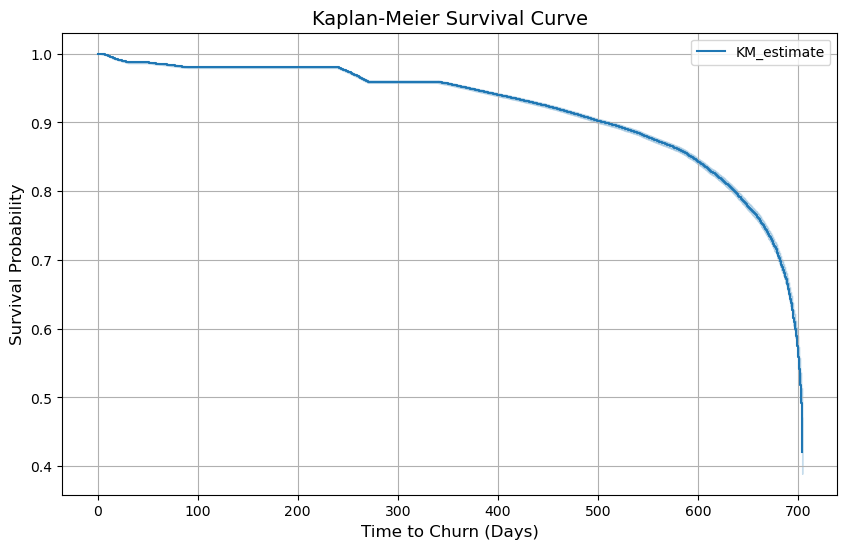

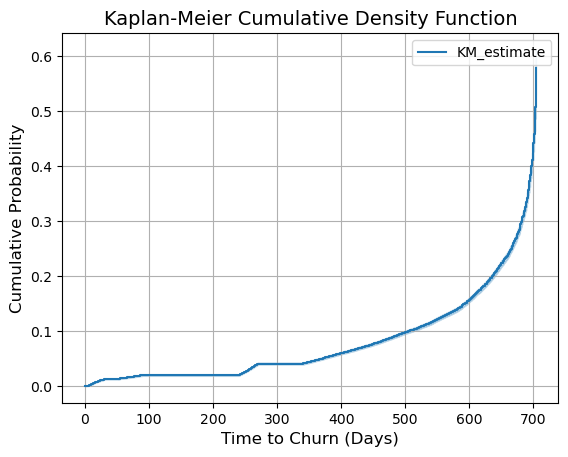

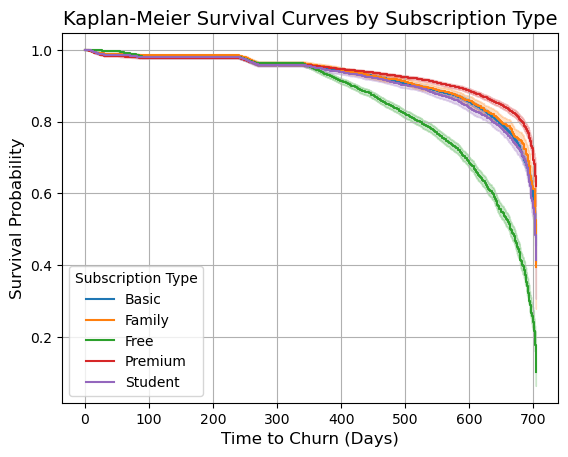

C:\Users\arabe\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column FeatureUsagePercentage have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Churn'].astype(bool)
>>> print(df.loc[events, 'FeatureUsagePercentage'].var())
>>> print(df.loc[~events, 'FeatureUsagePercentage'].var())

A very low variance means that the column FeatureUsagePercentage completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\arabe\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io

<lifelines.CoxPHFitter: fitted with 53344 total observations, 45322 right-censored observations>
             duration col = 'TimeToChurn'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 53344
number of events observed = 8022
   partial log-likelihood = -63174.53
         time fit was run = 2024-12-19 12:49:27 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
FeatureUsagePercentage -0.35      0.70      0.01           -0.37           -0.34                0.69                0.71
LoginFrequencyMonthly   0.13      1.14      0.00            0.12            0.14                1.13                1.15
CustomerFeedbackScore   0.40      1.49      0.02            0.36            0.44                1.44                1.55

                        cmp to      z      p  -log2(p)
covariate                                             
FeatureUsagePercentage    0.00 -40.35 <0.005       inf
LoginFrequencyMonthly     0.00  27.61 <0.005    554.96
CustomerFeedbackScore     0.00  20.82 <0.005    317.53
---
Concordance = 0.95
Partial AIC = 126355.05
log-likelihood ratio test = 34890.17 on 3 df
-log2(p) of ll-ratio test = inf

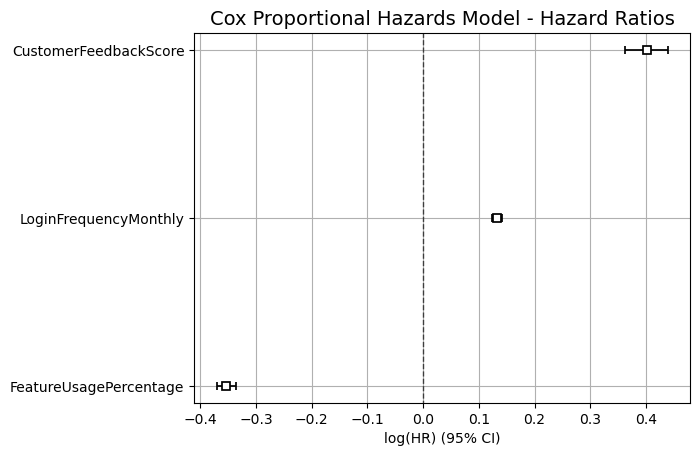

In [170]:
# Step 1: Prepare the data
# Ensure the dataset has 'TimeToChurn' as the duration and 'Churn' as the event indicator
survival_data = df[['TimeToChurn', 'Churn']].dropna()

# Step 2: Kaplan-Meier Survival Curve
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier model
kmf.fit(survival_data['TimeToChurn'], event_observed=survival_data['Churn'])

# Plot the survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve', fontsize=14)
plt.xlabel('Time to Churn (Days)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(True)
plt.show()

kmf.plot_cumulative_density()
plt.title('Kaplan-Meier Cumulative Density Function', fontsize=14)
plt.xlabel('Time to Churn (Days)', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.grid(True)
plt.show()

# Step 3: Stratified Survival Analysis (e.g., by SubscriptionType)
if 'SubscriptionType' in df.columns:
    for group, subset in survival_data.groupby(df['SubscriptionType']):
        kmf.fit(subset['TimeToChurn'], event_observed=subset['Churn'], label=str(group))
        kmf.plot_survival_function()

    plt.title('Kaplan-Meier Survival Curves by Subscription Type', fontsize=14)
    plt.xlabel('Time to Churn (Days)', fontsize=12)
    plt.ylabel('Survival Probability', fontsize=12)
    plt.legend(title='Subscription Type')
    plt.grid(True)
    plt.show()

# Step 4: Cox Proportional Hazards Model
# Include predictors for the Cox model
cox_data = df[['TimeToChurn', 'Churn', 'FeatureUsagePercentage',
                        'LoginFrequencyMonthly', 'CustomerFeedbackScore']].dropna()

cph = CoxPHFitter()
cph.fit(cox_data, duration_col='TimeToChurn', event_col='Churn')

# Print model summary
cph.print_summary()

# Plot the hazard ratios
cph.plot()
plt.title('Cox Proportional Hazards Model - Hazard Ratios', fontsize=14)
plt.grid(True)
plt.show()


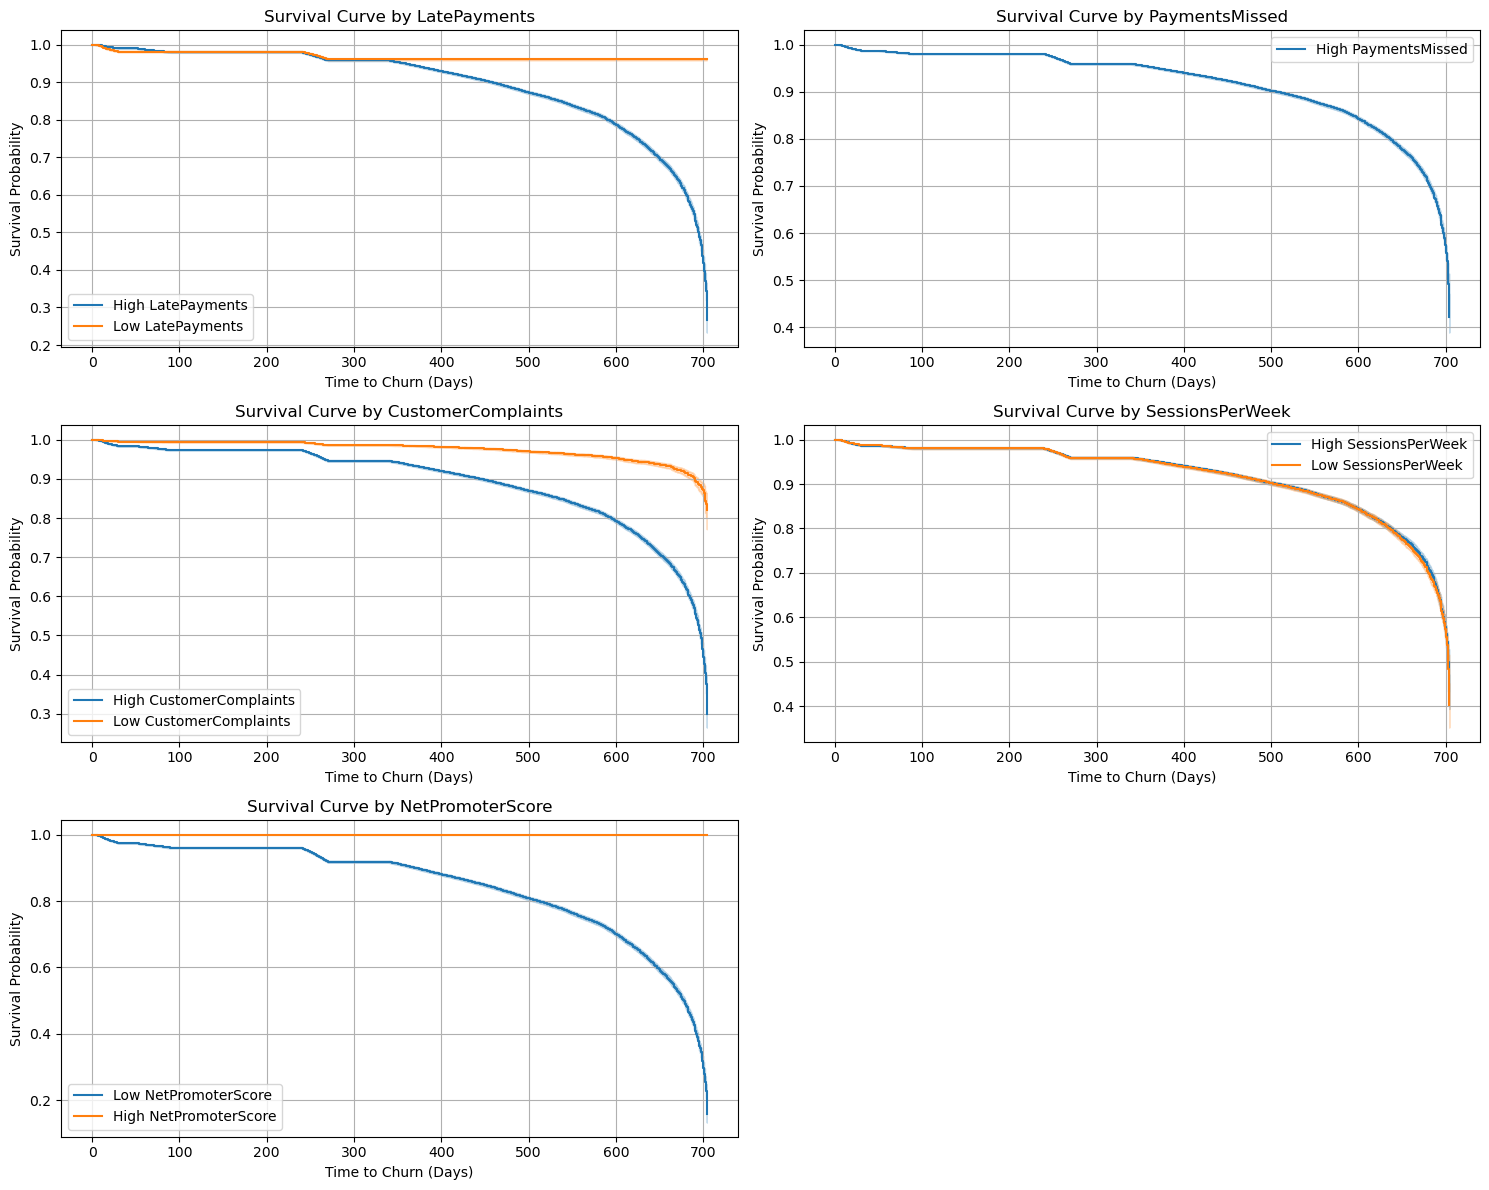

In [171]:
# Step 1: Prepare the data
# Select required columns and drop missing values
selected_features = ['TimeToChurn', 'Churn', 'LatePayments', 'PaymentsMissed',
                     'CustomerComplaints', 'SessionsPerWeek', 'NetPromoterScore']

survival_data = df[selected_features].dropna()

# Step 2: Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Step 3: Define a function to plot survival curves for high/low feature values
def plot_km_curves(data, feature, ax):
    median_value = data[feature].median()
    data['Group'] = np.where(data[feature] >= median_value, f'High {feature}', f'Low {feature}')

    for group in data['Group'].unique():
        group_data = data[data['Group'] == group]
        kmf.fit(group_data['TimeToChurn'], event_observed=group_data['Churn'], label=group)
        kmf.plot(ax=ax)

    ax.set_title(f"Survival Curve by {feature}", fontsize=12)
    ax.set_xlabel("Time to Churn (Days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)

# Step 4: Plot survival curves for the selected features
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # Create subplots
axes = axes.flatten()  # Flatten axes for easy iteration

features_to_plot = ['LatePayments', 'PaymentsMissed', 'CustomerComplaints',
                    'SessionsPerWeek', 'NetPromoterScore']

# Plot each feature
for i, feature in enumerate(features_to_plot):
    plot_km_curves(survival_data, feature, axes[i])

# Hide empty subplot (6th position)
fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()
plt.show()


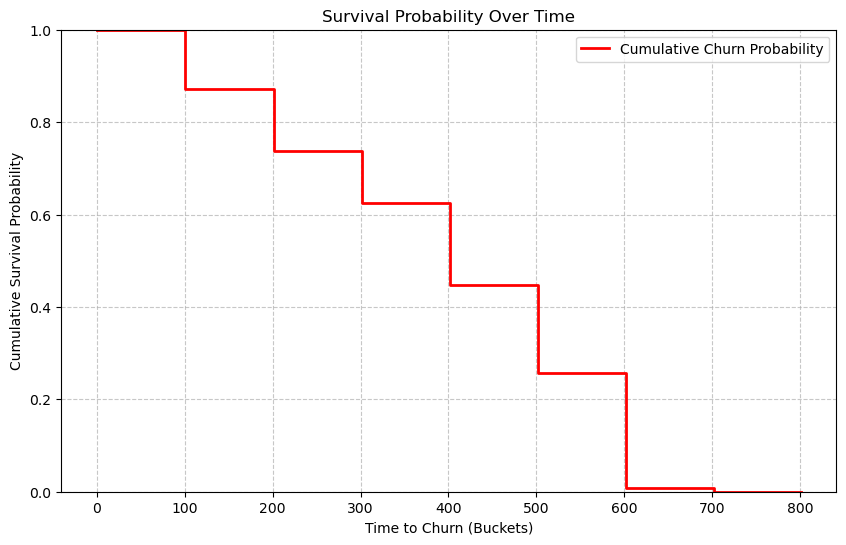

In [174]:


# Data from Excel
time_intervals = [0, 101, 202, 302, 402, 502, 602, 702, 801]
cumulative_p = [1.0, 0.8726, 0.7385, 0.6243, 0.4469, 0.2575, 0.0076, 0.0, 0.0]

# Create the step chart
plt.figure(figsize=(10, 6))
plt.step(time_intervals, cumulative_p, where='post', color='red', linewidth=2, label='Cumulative Churn Probability')

# Add labels, title, and legend
plt.title('Survival Probability Over Time')
plt.xlabel('Time to Churn (Buckets)')
plt.ylabel('Cumulative Survival Probability')
plt.ylim(0, 1)  # To ensure the graph scales properly
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()


# Show the plot
plt.show()